### NNCLR
*  Nearest- Neighbor Contrastive Learning of visual Representations (NNCLR), samples the nearest neighbors from the dataset in the latent space, and treats them as positives. This provides more semantic variations than pre-defined transformations.
* NNCLR Formulated by Google Research and DeepMind

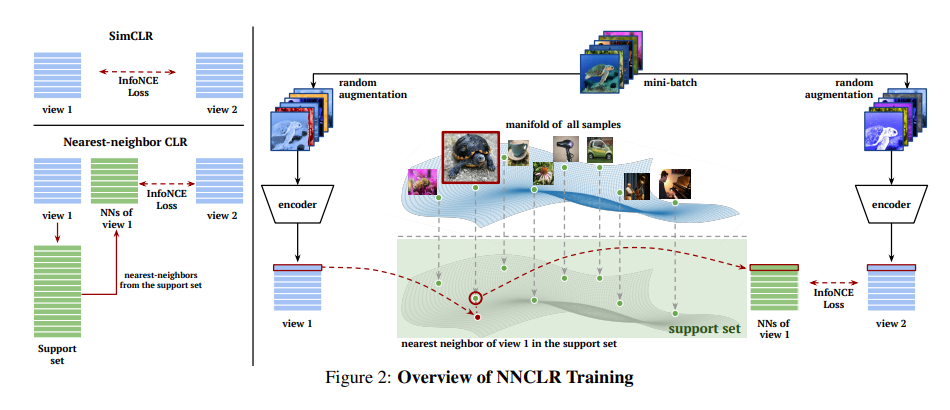

In [1]:
# !pip install lightly av torch-summary

In [2]:
import torch
from torch import nn
import torchvision

from lightly.data import LightlyDataset
from lightly.data import SimCLRCollateFunction
from lightly.loss import NTXentLoss
from lightly.models.modules import NNCLRProjectionHead
from lightly.models.modules import NNCLRPredictionHead
from lightly.models.modules import NNMemoryBankModule

In [3]:
class NNCLR(nn.Module):
    def __init__(self, backbone):
        super().__init__()

        self.backbone = backbone
        self.projection_head = NNCLRProjectionHead(512, 512, 128)
        self.prediction_head = NNCLRPredictionHead(128, 512, 128)

    def forward(self, x):
        y = self.backbone(x).flatten(start_dim=1)
        z = self.projection_head(y)
        p = self.prediction_head(z)
        z = z.detach()
        return z, p

In [20]:
resnet = torchvision.models.resnet18()
backbone = nn.Sequential(*list(resnet.children())[:-1])
model = NNCLR(backbone)

In [21]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

NNCLR(
  (backbone): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)


In [22]:
memory_bank = NNMemoryBankModule(size=4096)
memory_bank.to(device)

NNMemoryBankModule()

In [23]:
cifar10 = torchvision.datasets.CIFAR10("datasets/cifar10", download=True)
dataset = LightlyDataset.from_torch_dataset(cifar10)

Files already downloaded and verified


In [24]:
collate_fn = SimCLRCollateFunction(input_size=32)

In [25]:
dataloader = torch.utils.data.DataLoader(
    dataset,
    batch_size=256,
    collate_fn=collate_fn,
    shuffle=True,
    drop_last=True,
    num_workers=8,
)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [26]:
criterion = NTXentLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.06)

In [27]:
print("Starting Training")
for epoch in range(5):
    total_loss = 0
    for (x0, x1), _, _ in dataloader:
        x0 = x0.to(device)
        x1 = x1.to(device)
        z0, p0 = model(x0)
        z1, p1 = model(x1)
        z0 = memory_bank(z0, update=False)
        z1 = memory_bank(z1, update=True)
        loss = 0.5 * (criterion(z0, p1) + criterion(z1, p0))
        total_loss += loss.detach()
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
    avg_loss = total_loss / len(dataloader)
    print(f"epoch: {epoch:>02}, loss: {avg_loss:.5f}")

Starting Training


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


epoch: 00, loss: 5.92507
epoch: 01, loss: 5.63271
epoch: 02, loss: 5.56626
epoch: 03, loss: 5.53036
epoch: 04, loss: 5.48902
